In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
from sklearn import model_selection
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Data Exploration

In [2]:
data = pd.read_csv('DL_IMG_Train.csv', sep = ';', usecols =['PatientSex','Age','cT','cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])
data.head()

,PatientSex,Age,cT,cN,adj_ctx,RT_scop_interval,ALL_CR_yesno
0,0,72,2,1,0,11.71,1
1,0,72,2,1,0,11.71,1
2,0,72,2,1,0,11.71,1
3,0,72,2,1,0,11.71,1
4,0,72,2,1,0,11.71,1


## Check missing data

In [4]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PatientSex,0,0.0
Age,0,0.0
cT,0,0.0
cN,0,0.0
adj_ctx,0,0.0
RT_scop_interval,0,0.0
ALL_CR_yesno,0,0.0


## Check Correlation Matrix 

<AxesSubplot:>

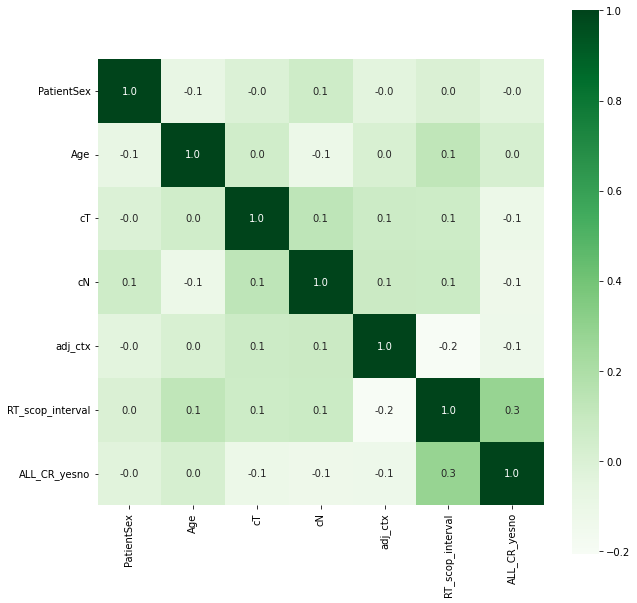

In [5]:
corr = data.corr()

# Plotting the heatmap of correlation between features
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':10}, cmap='Greens')

## Split train and test
*  Split manually so that each patient record is either in train or test set only
*  Select all available features

In [7]:
df_train = pd.read_csv('DL_IMG_Train.csv', sep = ';', usecols =['PatientSex','Age','cT','cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])  
df_test = pd.read_csv('DL_IMG_Test.csv', sep = ';', usecols =['PatientSex','Age','cT','cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])  

X_test = df_test.iloc[:,:-1] 
X_train = df_train.iloc[:,:-1] 
y_test = df_test['ALL_CR_yesno'] 
y_train = df_train['ALL_CR_yesno'] 

len(X_train), len(X_test)

(571, 151)

### Class distribution

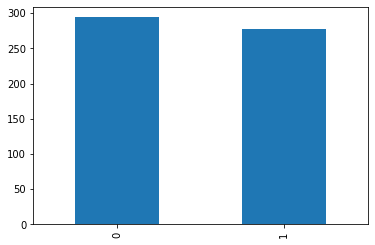

In [8]:
df_train['ALL_CR_yesno'].value_counts().plot(kind='bar'); 

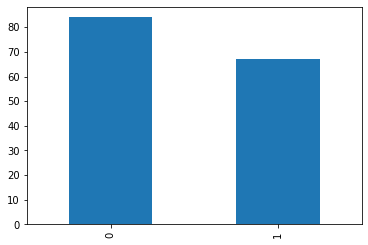

In [9]:
df_test['ALL_CR_yesno'].value_counts().plot(kind='bar');

## ML Model

In [4]:

mean_fp=[]
mean_tpr=[]

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: 
pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
        ('FFN', MLPClassifier(solver='lbfgs', hidden_layer_sizes=8, random_state=90210, learning_rate_init=0.0001)),
        ('SVM', SVC()),
        ('LogReg', LogisticRegression()),            
        ]
        
    
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['complete response', 'non-complete response']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

        
        final = pd.concat(dfs, ignore_index=True)
    return final

In [7]:
final = run_exps(X_train, y_train, X_test, y_test)

bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=500, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

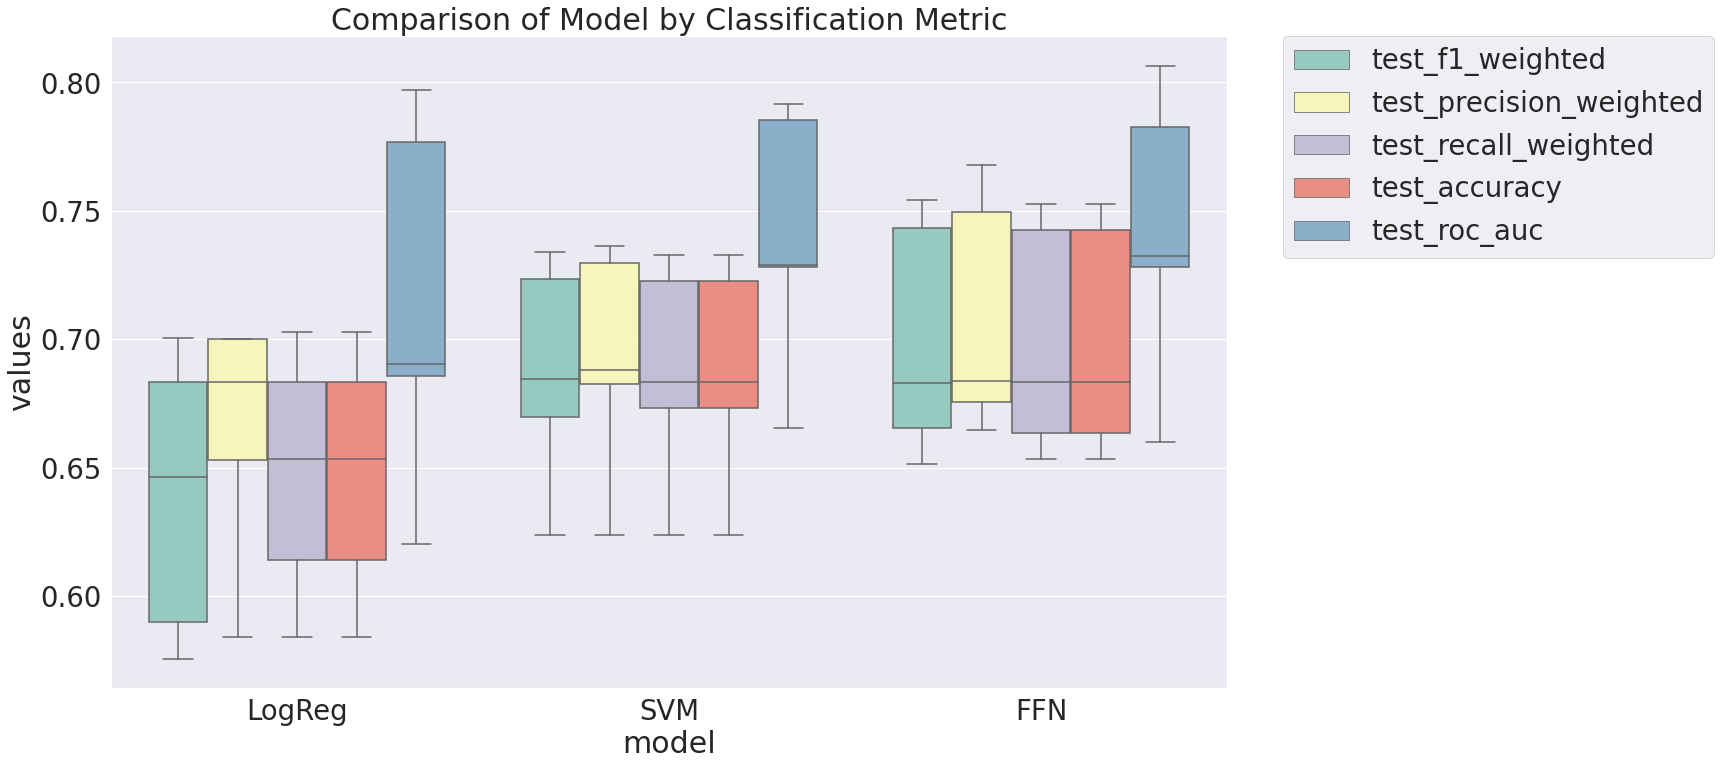

In [93]:

plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

## Feature Selection

              Specs       Score
5  RT_scop_interval  142.015612
4           adj_ctx    8.597594
3                cN    5.334132
2                cT    0.674806
1               Age    0.440408
0        PatientSex    0.436403


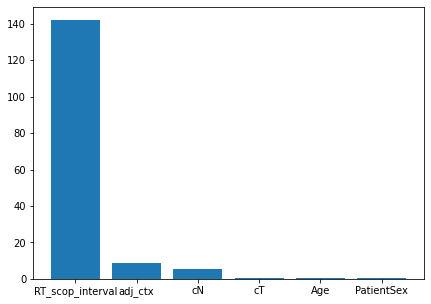

In [24]:
data = pd.read_csv('DL_IMG_Train.csv', sep = ';', usecols =['PatientSex','Age','cT','cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])

X = data.iloc[:,0:-1]  #independent columns
y = data.iloc[:,-1]    #target column 
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(6,'Score'))  


indices = np.argsort(fit.scores_)[::-1]
features = []
for i in range(6):
    features.append(X.columns[indices[i]])
        
plt.figure(figsize=[7,5])
plt.bar(features, fit.scores_[indices[range(6)]])
plt.show()

## Split train and test
*  Split manually so that patient record is either in train or test set only
*  Select the most important features based selected features (top 3)

In [10]:
df_train = pd.read_csv('DL_IMG_Train.csv', sep = ';', usecols =['cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])  
df_test = pd.read_csv('DL_IMG_Test.csv', sep = ';', usecols =['cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])  

X_test = df_test.iloc[:,:-1] 
X_train = df_train.iloc[:,:-1] 
y_test = df_test['ALL_CR_yesno'] 
y_train = df_train['ALL_CR_yesno'] 

len(X_train), len(X_test)

(571, 151)

In [ ]:
final = run_exps(X_train, y_train, X_test, y_test)

bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=500, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

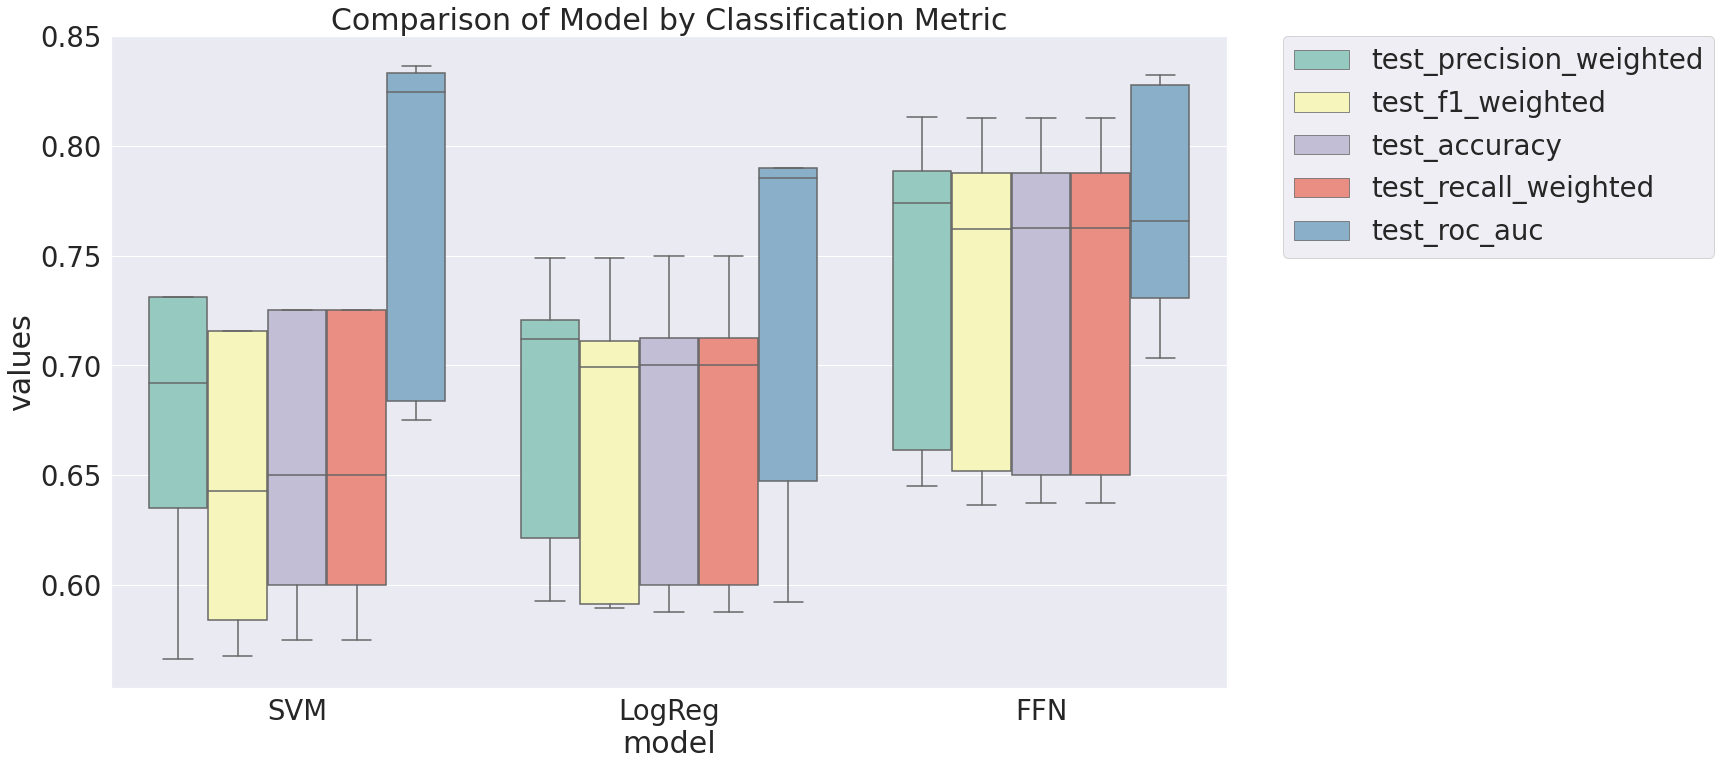

In [12]:

plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)